<a href="https://colab.research.google.com/github/vinismachadoo/otimizacao-petroleo-offshore/blob/main/producao_bacia_campos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install geopandas -q
!pip install pulp-q

     |████████████████████████████████| 40.6MB 95kB/s 


In [59]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import acos, cos, sin
from pulp import *

In [3]:
!wget 'http://hmlapp5.anp.gov.br/geoserver/oracleworskspace/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP'
!unzip 'ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP'

--2020-11-22 02:34:50--  http://hmlapp5.anp.gov.br/geoserver/oracleworskspace/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP
Resolving hmlapp5.anp.gov.br (hmlapp5.anp.gov.br)... 200.186.194.21
Connecting to hmlapp5.anp.gov.br (hmlapp5.anp.gov.br)|200.186.194.21|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP’

ows?service=WFS&ver     [       <=>          ] 505.56K   245KB/s    in 2.1s    

2020-11-22 02:34:53 (245 KB/s) - ‘ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&outputFormat=SHAPE-ZIP’ saved [517693]

Archive:  ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&maxFeatures=500&o

In [4]:
!wget 'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/RJ/rj_municipios.zip'
!unzip rj_municipios.zip

--2020-11-22 02:34:53--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/RJ/rj_municipios.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 170.84.40.11
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|170.84.40.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5164588 (4.9M) [application/zip]
Saving to: ‘rj_municipios.zip’

rj_municipios.zip   100%[===================>]   4.92M   763KB/s    in 6.6s    

2020-11-22 02:35:01 (763 KB/s) - ‘rj_municipios.zip’ saved [5164588/5164588]

Archive:  rj_municipios.zip
 extracting: RJ_Municipios_2019.cpg  
  inflating: RJ_Municipios_2019.dbf  
  inflating: RJ_Municipios_2019.prj  
  inflating: RJ_Municipios_2019.shp  
  inflating: RJ_Municipios_2019.shx  


In [5]:
campos_producao = gpd.read_file('CAMPOS_PRODUCAO_SIRGASPolygon.shp')
municipios_rj = gpd.read_file('RJ_Municipios_2019.shp')

In [6]:
bacia_campos = campos_producao[campos_producao.NOM_BACIA == 'Campos']

In [7]:
operadores = {
    'Shell Brasil Petróleo Ltda.': 'Shell Brasil',
    'Dommo Energia S.A': 'Dommo Energia',
    'Total E&P do Brasil Ltda.': 'Total E&P',
    'BW Energy Maromba do Brasil LTDA': 'BW Energy',
    'Petróleo Brasileiro S.A.': 'Petrobras',
    'Petro Rio O&G Exploração e Produção de Petróleo Ltda.': 'Petro Rio O&G',
    'Equinor Brasil Energia Ltda.': 'Equinor Brasil',
    'Perenco Petróleo e Gás do Brasil Ltda.': 'Perenco Brasil',
    'Petro Rio Jaguar Petróleo Ltda.': 'Petro Rio O&G'
}

bacia_campos.OPERADOR_C.replace(operadores, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [37]:
ueps_operacao = pd.read_csv('http://www.anp.gov.br/arquivos/dados-ep/ueps-operacao.csv', sep=';', header=1)
plataformas = ueps_operacao[ueps_operacao['Bacia '] == 'Campos '].set_index('Sigla')

In [38]:
plataformas_latitude = plataformas.Latitude.str.replace(",",".").str.split(":", expand=True)
plataformas['latitude_decimal'] = plataformas_latitude[0].astype(int) - plataformas_latitude[1].astype(float) / 60 - plataformas_latitude[2].astype(float) / 3600
plataformas['latitude_radianos'] = np.deg2rad(plataformas['latitude_decimal'])

plataformas_longitude = plataformas.Longitude.str.replace(",",".").str.split(":", expand=True)
plataformas['longitude_decimal'] = plataformas_longitude[0].astype(int) - plataformas_longitude[1].astype(float) / 60 - plataformas_longitude[2].astype(float) / 3600
plataformas['longitude_radianos'] = np.deg2rad(plataformas['longitude_decimal'])

In [39]:
demanda_mapa = {
    'FPSO': 45,
    'FIXA': 45,
    'SEMI SUBMERSÍVEL': 73,
    'FPU': 55,
    'TLWP': 55
}
plataformas['demanda'] = plataformas.Tipo.map(demanda_mapa)

In [40]:
plataformas

,Nome,Bacia,Tipo,Operador,Latitude,Longitude,Lâmina D'água (m),Capacidade de Processamento Petróleo (bbl/dia),Capacidade de Processamento Gás (Mil m³/dia),latitude_decimal,latitude_radianos,longitude_decimal,longitude_radianos,demanda
Sigla,,,,,,,,,,,,,,
CAPX,FPSO CAPIXABA,Campos,FPSO,Petrobras,"-21:14:16,783","-39:57:46,397",1350,110000,3200,-21.237995,-0.370673,-39.962888,-0.697484,45
FCDA,FPSO CIDADE DE ANCHIETA,Campos,FPSO,Petrobras,"-21:20:16,965","-40:03:27,174",1221,100000,3500,-21.338046,-0.372419,-40.057548,-0.699136,45
FPCGZ,FPSO Cidade de Campos dos Goytacazes,Campos,FPSO,Petrobras,"-22:57:12,165","-40:43:31,966",765,150000,3500,-22.953379,-0.400612,-40.725546,-0.710795,45
FPNT,FPSO CIDADE DE NITEROI,Campos,FPSO,Petrobras,"-22:29:47,688","-39:56:14,785",1370,100000,3500,-22.496580,-0.392639,-39.937440,-0.697040,45
FPSO ESP SANTO,FPSO ESPIRITO SANTO,Campos,FPSO,Shell Brasil,"-21:12:30,854","-39:44:33,774",1775,100000,1400,-21.208571,-0.370159,-39.742715,-0.693641,45
FPSO FLUMINENSE,FPSO Fluminense,Campos,FPSO,Shell Brasil,"-22:38:57,206","-40:25:43,286",607,70000,2124,-22.649224,-0.395304,-40.428691,-0.705614,45
FPSO FRADE,FPSO FRADE,Campos,FPSO,Chevron Frade,"-21:53:03,196","-39:51:30,700",1065,100000,3000,-21.884221,-0.381952,-39.858528,-0.695663,45
OSX1,FPSO_OSX1,Campos,FPSO,Dommo Energia,"-23:32:07,003","-41:26:12,643",130,40000,1500,-23.535279,-0.410768,-41.436845,-0.723209,45
OSX3,FPSO_OSX3,Campos,FPSO,Dommo Energia,"-23:08:08,977","-41:04:24,717",105,100000,1500,-23.135827,-0.403796,-41.073533,-0.716868,45


In [42]:
aeroportos_data = {
    'Sigla': ['SBCP', 'SBME', 'SBFS', 'SBCB'],
    'Latitude': ['-21:42:04', '-22:20:34', '-22:01:44', '-22:55:15'],
    'Longitude': ['-41:18:28', '-41:45:50', '-41:04:11', '-42:04:17']
}
aeroportos = pd.DataFrame(aeroportos_data).set_index('Sigla')

In [43]:
aeroportos_latitude = aeroportos.Latitude.str.replace(",",".").str.split(":", expand=True)
aeroportos['latitude_decimal'] = aeroportos_latitude[0].astype(int) - aeroportos_latitude[1].astype(float) / 60 - aeroportos_latitude[2].astype(float) / 3600
aeroportos['latitude_radianos'] = np.deg2rad(aeroportos['latitude_decimal'])

aeroportos_longitude = aeroportos.Longitude.str.replace(",",".").str.split(":", expand=True)
aeroportos['longitude_decimal'] = aeroportos_longitude[0].astype(int) - aeroportos_longitude[1].astype(float) / 60 - aeroportos_longitude[2].astype(float) / 3600
aeroportos['longitude_radianos'] = np.deg2rad(aeroportos['longitude_decimal'])

In [44]:
aeroportos

,Latitude,Longitude,latitude_decimal,latitude_radianos,longitude_decimal,longitude_radianos
Sigla,,,,,,
SBCP,-21:42:04,-41:18:28,-21.701111,-0.378756,-41.307778,-0.720957
SBME,-22:20:34,-41:45:50,-22.342778,-0.389955,-41.763889,-0.728917
SBFS,-22:01:44,-41:04:11,-22.028889,-0.384477,-41.069722,-0.716802
SBCB,-22:55:15,-42:04:17,-22.920833,-0.400044,-42.071389,-0.734284


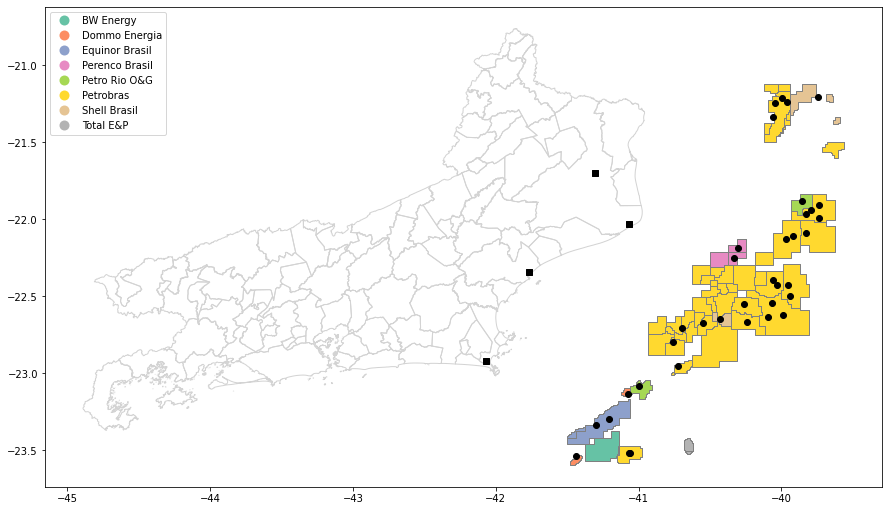

In [45]:
fig, ax = plt.subplots(figsize = (15,10))
bacia_campos.plot(ax=ax, ec='gray', column='OPERADOR_C', cmap='Set2', legend=True, legend_kwds={'loc': 'upper left'})
municipios_rj.plot(ax=ax, fc='None', ec='lightgray')
ax.scatter(plataformas['longitude_decimal'], plataformas['latitude_decimal'], color='black')
ax.scatter(aeroportos['longitude_decimal'], aeroportos['latitude_decimal'], color='black', marker='s')

plt.show()

In [54]:
OPERADORES = set(plataformas.Operador.unique())
PLATAFORMAS = set(plataformas.index)
AEROPORTOS = set(aeroportos.index)

In [55]:
def calcula_distancia(p,a):
    d = 2*6378*acos(
        cos(
            plataformas['longitude_radianos'][p] - aeroportos['longitude_radianos'][a]
        )*cos(
            plataformas['latitude_radianos'][p]
        )*cos(
            aeroportos['latitude_radianos'][a]
        )+sin(
            plataformas['latitude_radianos'][p]
        )*sin(
            aeroportos['latitude_radianos'][a]
        ))
    return d

distancia = {}
for p in PLATAFORMAS:
    dd = {a:calcula_distancia(p,a) for a in AEROPORTOS}
    distancia[p] = dd

In [ ]:
# PERMITE_ALOCACAO = {} # domain [op][p] ; 1 se o a plataforma p pertence ao operador o, 0 caso contrario
# for o in OPERADORES:
#     valores = {}
#     for p in PLATAFORMAS:
#         permite = 0
#         if plataformas['o'][p] == o:
#             permite = 1
#         valores[p] = permite
#     PERMITE_ALOCACAO[o] = valores

In [69]:
pb = LpProblem('Facility', LpMinimize)
x = LpVariable.dicts('x', (PLATAFORMAS, AERODROMOS), cat='Binary')
pb += lpSum([[distancia[p][a]*plataformas['demanda'][p]*x[p][a] for p in PLATAFORMAS] for a in AEROPORTOS])
for p in PLATAFORMAS:
    pb += lpSum([x[p][a] for a in AEROPORTOS]) == 1

pb.solve()
print("Status:", LpStatus[pb.status])

Status: Optimal


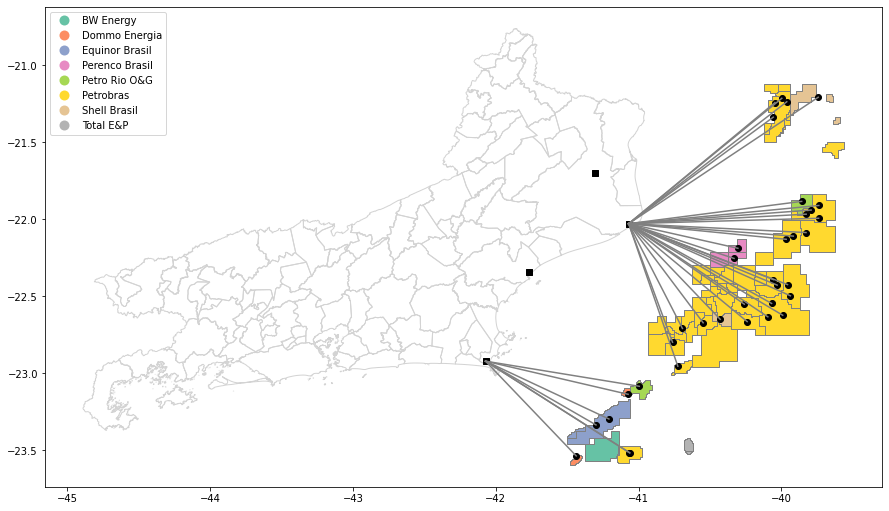

In [66]:
fig, ax = plt.subplots(figsize = (15,10))
bacia_campos.plot(ax=ax, ec='gray', column='OPERADOR_C', cmap='Set2', legend=True, legend_kwds={'loc': 'upper left'})
municipios_rj.plot(ax=ax, fc='None', ec='lightgray')
ax.scatter(plataformas['longitude_decimal'], plataformas['latitude_decimal'], color='black')
ax.scatter(aeroportos['longitude_decimal'], aeroportos['latitude_decimal'], color='black', marker='s')
for p in PLATAFORMAS:
    for a in AEROPORTOS:
        if value(x[p][a]) == 1:
            ax.plot([plataformas.longitude_decimal[p], aeroportos.longitude_decimal[a]],
                    [plataformas.latitude_decimal[p], aeroportos.latitude_decimal[a]], color='gray')